# COGS 108 - EDA Checkpoint

# Names

- Bridget Egan 
- Dillan Merchant
- Jennifer Hang
- Sam Zakeri
- Connie Chang

<a id='research_question'></a>
# Research Question

**How are American news headline sentiments correlated to their publication source's political leanings?** To do this, we wanted three sources that reflected 'far-left', 'centrist', and 'far-right' political leanings. Using both AllSides and MediaBiasFactCheck, Breitbart was evaluated as the most right-leaning news source of our dataset, CNN was evaluated as the most left-leaning news source, and NPR was evaluated as the most politically-centrist news source [1, 2, 3, 4, 5, 6, 7]. *We hypothesize that the two more politically polar news sources, Breitbart and CNN, will have more polar sentiment (as in frequently positive or negative-- bimodal distribution), and the more centrist news source, NPR, will be more neutral in sentiment.*
- [1] https://www.allsides.com/news-source/cnn-media-bias
- [2] https://mediabiasfactcheck.com/cnn/
- [3] https://mediabiasfactcheck.com/npr/
- [4] https://www.allsides.com/news-source/npr-media-bias
- [5] https://www.allsides.com/news-source/breitbart
- [6] https://mediabiasfactcheck.com/breitbart/
- [7] https://www.adfontesmedia.com/static-mbc/

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import word_tokenize, sent_tokenize, tokenize
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer, SnowballStemmer
#from nltk.stem.snowball import Snowball
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/began/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Cleaning

The data is fairly clean to begin with, there are few missing values and the format is consistent throughout. The issue we have is there is a lot of data that we do not need to use. So, to get our data into a useable format, we will only select the three publications we plan to use, Breitbart, CNN, and NPR, and keep the dates and headlines from only 1,000 of each. We decided on 1,000 of each because the dataset had a higher number of Breitbart articles than any other publication, and we wanted there to be a standard number of headlines for each source. Given that we plan on doing the additional step of sentiment analysis after this data checkpoint, most of our EDA will come next week, and so data distribution checking or data transformations will not be necessary at this time. It is also possible that as this project proceeds, we may decide to add in more points of data analysis, such as increasing how many articles we analyze from each news source, or even adding in different news sources to give us data for a 'center-right' and 'center-left source', if we feel that would improve the strength of our project.

In [2]:
#this imports the relevant data sets from three separate files, and sanitizes the input.

news1 = pd.read_csv('csv_files/articles1.csv', engine = 'python', error_bad_lines=False)
news2 = pd.read_csv('csv_files/articles2.csv', engine = 'python', error_bad_lines=False)
news3 = pd.read_csv('csv_files/articles3.csv', engine = 'python', error_bad_lines=False)


print(news1.shape)
print(news2.shape)
print(news3.shape)

Skipping line 17535: field larger than field limit (131072)
Skipping line 1429: field larger than field limit (131072)
Skipping line 1469: field larger than field limit (131072)
Skipping line 1516: field larger than field limit (131072)
Skipping line 1740: field larger than field limit (131072)
Skipping line 3774: field larger than field limit (131072)
Skipping line 3779: field larger than field limit (131072)
Skipping line 3791: field larger than field limit (131072)
Skipping line 33121: field larger than field limit (131072)
Skipping line 34127: field larger than field limit (131072)


(49999, 10)
(49992, 10)
(42569, 10)


In [3]:
# combine three dataframes into one
news = news1.append(news2).append(news3)
news.shape

(142560, 10)

In [4]:
news.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [5]:
# check number of news for each source
news['publication'].value_counts()

Breitbart              23780
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11112
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7172
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [6]:
news_cleaned = news[['title', 'publication', 'date']]
news_cleaned.head()

,title,publication,date
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02


In [7]:
news_cleaned = news_cleaned.dropna()
news_cleaned.isnull().values.any()

False

In [8]:
# keep news only from 'Breitbart', 'CNN', and 'NPR'
sources = ['Breitbart', 'CNN', 'NPR']
news = news_cleaned[news_cleaned['publication'].isin(sources)]

news['publication'].value_counts()

Breitbart    23780
NPR          11992
CNN          11488
Name: publication, dtype: int64

In [9]:
# pick 1000 random news for each source
news = news.groupby("publication").sample(n=1000)

news['publication'].value_counts()

NPR          1000
Breitbart    1000
CNN          1000
Name: publication, dtype: int64

In [10]:
news.head()

,title,publication,date
30141,A Year After Honoring a Man in a Dress for Cou...,Breitbart,2016-06-22
30950,Iran: Rogue Jews In WH To Blame For Sanctions ...,Breitbart,2016-01-18
11753,Pelosi: ’I Never Thought I Would Pray for the ...,Breitbart,2017-04-30
15246,"London Terrorists Named: Known to Police, Born...",Breitbart,2017-06-05
9795,Donald Trump Signs Bills Assisting Law Enforce...,Breitbart,2017-06-03


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [11]:
news['title'] = news['title'].astype(str)

## Lowercase
news['title'] = news['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove punct
def remove_punct(string):
    punctuation= '''‘’!()-[]{};:'", <>./?@#$%^&*_~'''
    for x in punctuation:
        string = string.replace(x, " ")
    return string

news['title'] = news['title'].apply(remove_punct)

#tokenize 
news['title'] = news['title'].apply(word_tokenize)


##stemming 
stemmer = PorterStemmer()
news['title'] = news['title'].apply(lambda x: [stemmer.stem(y) for y in x])


## stop word remove
stop_words = set(stopwords.words('english'))
news['title'] = news['title'].apply(lambda x: [item for item in x if item not in stop_words])

# putting them back into lists
def joiner(title_list): 
    return ' '.join(title_list)
news['title'] = news['title'].apply(joiner)

analyser = SentimentIntensityAnalyzer()

title_sentences = list(news['title'])
def senti(input_list):
    output = pd.DataFrame()
    for sentence in title_sentences:
        ss = analyser.polarity_scores(sentence)
        ss['cleaned_titles'] = sentence
        output = output.append(ss, ignore_index=True)
    return output


news_sentiments = senti(title_sentences)



In [12]:
news_sentiments
title_sentiments = pd.DataFrame(news_sentiments['compound']) 


title_sentiments
## TRYING TO JOIN NEWS AND TITLE_SENTIMENTS SO THAT COMPOUND IS THE NAME OF A COLUMN IN NEWS 
news = news.reset_index()
news['title_sentiment']  = news_sentiments['compound']
news

,index,title,publication,date,title_sentiment
0,30141,year honor man dress courag espn honor man boy...,Breitbart,2016-06-22,0.7506
1,30950,iran rogu jew wh blame sanction tehran,Breitbart,2016-01-18,-0.3400
2,11753,pelosi never thought would pray day bush presi...,Breitbart,2017-04-30,-0.2411
3,15246,london terrorist name known polic born pakistan,Breitbart,2017-06-05,-0.6908
4,9795,donald trump sign bill assist law enforc behin...,Breitbart,2017-06-03,0.0000
...,...,...,...,...,...
2995,15670,editor choic 9 global feel good stori 2016,NPR,2016-12-22,0.4404
2996,14601,ride hail app new economi invis discrimin,NPR,2016-11-04,0.0772
2997,14130,survey say american get stress elect,NPR,2016-10-15,-0.4215
2998,5339,green beret sit portrait hi former command chief,NPR,2017-03-04,0.0000


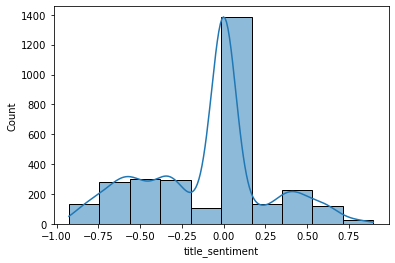

In [13]:
sns.histplot(news['title_sentiment'], bins=10, kde=True);


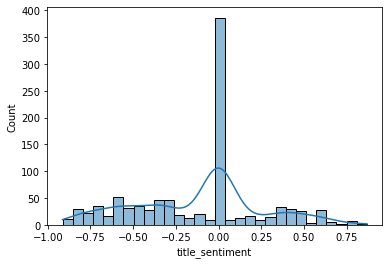

In [16]:
breitbart = news[news['publication'] == 'Breitbart']
sns.histplot(breitbart['title_sentiment'], bins=30, kde=True);

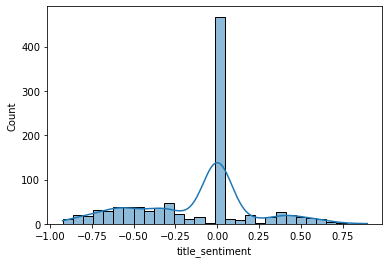

In [17]:
cnn = news[news['publication'] == 'CNN']
sns.histplot(cnn['title_sentiment'], bins=30, kde=True);

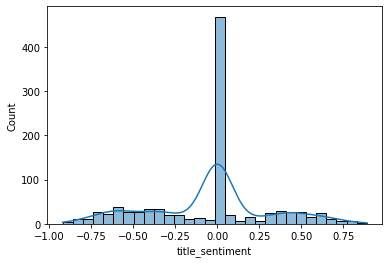

In [15]:
npr = news[news['publication'] == 'NPR']
sns.histplot(npr['title_sentiment'], bins=30, kde=True);

In [18]:
news.head()

,index,title,publication,date,title_sentiment
0,30141,year honor man dress courag espn honor man boy...,Breitbart,2016-06-22,0.7506
1,30950,iran rogu jew wh blame sanction tehran,Breitbart,2016-01-18,-0.3400
2,11753,pelosi never thought would pray day bush presi...,Breitbart,2017-04-30,-0.2411
3,15246,london terrorist name known polic born pakistan,Breitbart,2017-06-05,-0.6908
4,9795,donald trump sign bill assist law enforc behin...,Breitbart,2017-06-03,0.0000
